In [901]:
import pandas as pd
import numpy as np

import matplotlib
import seaborn
import matplotlib.dates as md
import statistics
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

In [902]:
#Store the national holidays of USA between the desired time period in the variable holidays
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
cal = calendar()
holidays = cal.holidays(start='2016-07-13', end='2017-05-31')

In [932]:
#read the data into jupyter notebook. The value of CPM is already being calcluated in excel itself using formula: 
#(1000*revenue)/pageviews 

df=pd.read_csv("C:/Users/shahvr/Desktop/vru/test.csv")

In [933]:
# df['CPM']=(1000*df['revenue'])/df['pageviews']

In [904]:
#Converting the date to date time format
df['date']=pd.to_datetime(df['date'])

In [905]:
#creating a binary variable holiday that will indicate if the given date in the dataset is national holiday or no
df['holiday'] = df['date'].astype('datetime64').isin(holidays)
df['holiday']= df['holiday'].astype(int)

In [906]:
#Creating the variable quarter (4 quarters of the year)
import datetime as dt
df['quarter'] = df['date'].astype('datetime64').dt.quarter

In [907]:
#Extracting month from the date variable
df['month'] = df['date'].astype('datetime64').dt.month

In [908]:
# the day of the week (Monday=0, Sunday=6) and if its a weekday or weekend
df['DayOfTheWeek'] = df['date'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)
df['WeekEnd'] = (df['DayOfTheWeek'] > 4).astype(int)
# To select an estimation of anomaly population (here I wanted to test for 2% but we can change it according to the needs)
outliers_fraction = 0.02

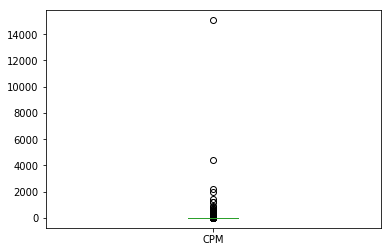

In [909]:
#box plot for CPM
df['CPM'].plot(kind='box')
plt.show()

In [910]:
test=df[df.date > '2017/04/01']
train=df[df.date < '2017/04/01']

In [911]:
# Take useful feature and standardize them 
data = train[['CPM', 'DayOfTheWeek', 'WeekEnd','holiday','month','quarter']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
# train one class SVM 
model =  OneClassSVM(nu=0.95 * outliers_fraction) #nu=0.95 * outliers_fraction  + 0.05
data = pd.DataFrame(np_scaled)
model.fit(data)
# add the data to the train dataset 
train['anomaly_SVM'] = model.predict(data)
train['anomaly_SVM'] = train['anomaly_SVM'].map( {1: 0, -1: 1} )
print(train['anomaly_SVM'].value_counts())

C:\Users\shahvr\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\shahvr\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


0    11758
1      203
Name: anomaly_SVM, dtype: int64


C:\Users\shahvr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\shahvr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [912]:
# predict and add the data to the test dataset 
data_2= test[['CPM', 'DayOfTheWeek', 'WeekEnd','holiday','month','quarter']]
test['anomaly_SVM'] = model.predict(data_2)
test['anomaly_SVM'] = test['anomaly_SVM'].map( {1: 0, -1: 1} )
print(test['anomaly_SVM'].value_counts())

1    5690
Name: anomaly_SVM, dtype: int64


C:\Users\shahvr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\shahvr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


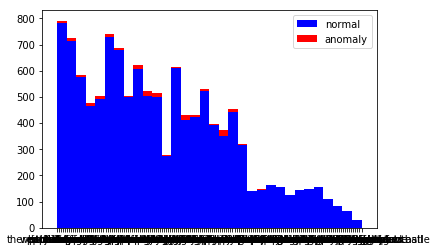

In [913]:
# visualisation of anomaly with site only on train data
a = train.loc[train['anomaly_SVM'] == 0, 'site']
b = train.loc[train['anomaly_SVM'] == 1, 'site']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

In [914]:
# Analysis without dividing the data into test
# Take useful feature and standardize them 
data = df[['CPM', 'DayOfTheWeek','WeekEnd','holiday','month','quarter']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
# train one class SVM 
model =  OneClassSVM(nu=0.95 * outliers_fraction) 
data = pd.DataFrame(np_scaled)
model.fit(data)
# add the data to the train dataset 
df['anomaly_SVM'] = model.predict(data)
df['anomaly_SVM'] = df['anomaly_SVM'].map( {1: 0, -1: 1} )
print(df['anomaly_SVM'].value_counts())


C:\Users\shahvr\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\shahvr\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


0    17459
1      288
Name: anomaly_SVM, dtype: int64


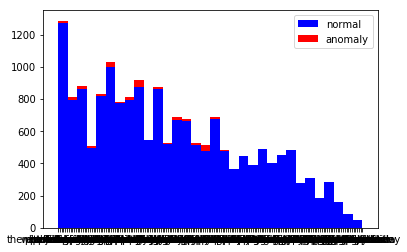

In [915]:
# visualisation of anomaly with site on whole data
a = df.loc[df['anomaly_SVM'] == 0, 'site']
b = df.loc[df['anomaly_SVM'] == 1, 'site']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

In [916]:
#2nd method but since in OneSVM dividing the data was not giving proper results hence here data was not divided
# Take useful feature and standardize them 
data = df[['CPM','DayOfTheWeek','holiday','month','quarter']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest 
model =  IsolationForest(contamination = outliers_fraction)
model.fit(data)
# add the data to the main dataset 
df['anomaly_Iso'] = pd.Series(model.predict(data))
df['anomaly_Iso'] = df['anomaly_Iso'].map( {1: 0, -1: 1} )
print(df['anomaly_Iso'].value_counts())

C:\Users\shahvr\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\shahvr\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\shahvr\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\Users\shahvr\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be rem

0    17392
1      355
Name: anomaly_Iso, dtype: int64


In [917]:
#Only the values which showed anomalies after running oneSVM were selected
d=df[df.anomaly_SVM==1]

In [918]:
#Finding the performance of the data by dividing the CPM column into 2 bins. All the values between 0 and median were
# considered underperform and all the values between median and maximum are considered overperform
d['performance'] = pd.cut(d.CPM,
                     bins=[d['CPM'].min(),statistics.median(d.CPM),d['CPM'].max()],
                     labels=["underperform","overperform"])

C:\Users\shahvr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [919]:
Performance=pd.DataFrame({'Performance':d.groupby(['site','performance']).size()})

In [920]:
Performance.sort_values(by=['Performance'],ascending=False)

,,Performance
site,performance,
mynfldraft,underperform,15
metschronicle,underperform,15
wsof,underperform,14
welikela,underperform,11
raiders411,underperform,10
bluemoon-mcfc,overperform,8
tidefans,underperform,8
sixpackspeak,overperform,7
readceltic,underperform,7


In [921]:
#Data was sorted first by site then date
f=d.sort_values(by=['site','date'])

In [922]:
#Here the variable in_block was created to find the consecutive days of anomalies
day = pd.Timedelta('1d')
f['in_block'] = ((f.date - f.date.shift(-1)).abs() == day) | (f.date.diff() == day)

In [923]:
f

,date,site,revenue,pageviews,CPM,holiday,quarter,month,DayOfTheWeek,WeekDay,WeekEnd,anomaly_SVM,anomaly_Iso,performance,in_block
8943,2017-02-25,49erswebzone,7.267473,28,259.552607,0,1,2,5,0,1,1,1,overperform,False
1107,2016-11-11,allhabs,0.763558,566,1.349042,1,4,11,4,1,0,1,1,overperform,False
4299,2016-12-26,allhabs,0.266752,245,1.088785,1,4,12,0,1,0,1,1,overperform,False
5328,2017-01-09,allhabs,0.093514,301,0.310679,0,1,1,0,1,0,1,0,underperform,False
3477,2016-12-16,angelswin,0.005045,241,0.020934,0,4,12,4,1,0,1,0,underperform,False
4073,2016-12-23,angelswin,0.004531,226,0.020048,0,4,12,4,1,0,1,0,underperform,False
4582,2016-12-30,angelswin,0.000925,184,0.005028,0,4,12,4,1,0,1,0,underperform,False
4767,2017-01-01,angelswin,0.000893,198,0.004510,0,1,1,6,0,1,1,0,underperform,True
4841,2017-01-02,angelswin,0.000525,222,0.002366,1,1,1,0,1,0,1,1,underperform,True
5283,2017-01-08,angelswin,0.000055,201,0.000274,0,1,1,6,0,1,1,0,underperform,False


In [926]:
#the consecutive dates were assigned a group number
f['breaks'] = f['date'].diff() != day
f['groups'] = breaks.cumsum()

In [925]:
#only the data which were consecutive were selected
h=f[f.in_block ==1]

In [927]:
#a final dataframe with site which showed consecutive anomalies for more than 1 day were shown
final=pd.DataFrame({'Site': h.groupby(['site','groups']).site.first(),
                    'BeginDate' : h.groupby(['site','groups']).date.first(), 
                    'EndDate' : h.groupby(['site','groups']).date.last(),
                    'Consecutive' : h.groupby(['site','groups']).size(),
                    'Perf': h.groupby(['site','groups']).performance.first()
                     }).reset_index(drop=True)

In [928]:
final[final.Consecutive > 1]
final.sort_values(['Consecutive'],ascending=False)

,Site,BeginDate,EndDate,Consecutive,Perf
10,elophant,2017-02-24,2017-02-26,3,overperform
1,autoweek,2017-02-24,2017-02-26,3,overperform
6,celticquicknews,2016-10-22,2016-10-24,3,overperform
7,destinytracker,2017-02-24,2017-02-26,3,overperform
8,dodgerblue,2017-02-24,2017-02-26,3,overperform
16,lakersnation,2016-10-22,2016-10-24,3,overperform
30,mynhltraderumors,2017-02-24,2017-02-26,3,overperform
14,huskermax,2017-02-24,2017-02-26,3,overperform
45,sixpackspeak,2016-12-04,2016-12-05,2,overperform
49,tidefans,2017-01-08,2017-01-09,2,underperform
